In [1]:
# Import modules and make matplotlib plot inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import ptemcee
import corner
%matplotlib inline  

# 1. Mock data (two point sources)

Let's first generate some mock image data (i.e. 2D array) that represents two point sources (e.g. a binary star system) and visualize it

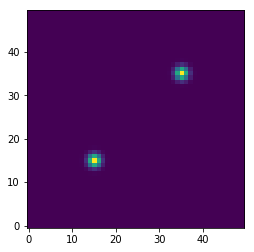

In [2]:
# Set up image
image_size = 50
x = np.linspace(0,image_size-1,image_size) # x coordinates
y = np.linspace(0,image_size-1,image_size) # y coordinates
xx,yy = np.meshgrid(x,y) # grid of x,y coordinates
# Position of first point source
x1 = 15
y1 = 15
# Position of second point source
x2 = 35
y2 = 35
# Peak and width of both point sources (constant to keep things simpler)
peak = 500
width = 1.0
# Compute distance to each source in image coordinates
dist1 = np.sqrt((xx-x1)**2.0+(yy-y1)**2.0)
dist2 = np.sqrt((xx-x2)**2.0+(yy-y2)**2.0)
# Add the Gaussian two point sources to the image
image = peak*np.exp(-0.5*dist1**2.0/width**2.0) + peak*np.exp(-0.5*dist2**2.0/width**2.0)
# Visualize this
plt.imshow(image,origin='lower');

Now let's add some noise to our mock image

In [3]:
# Generate some Gaussian noise
#gauss_noise_amp = 50
#gauss_noise = np.random.randn(image_size,image_size)
#plt.imshow(gauss_noise,origin='lower'); 

In [4]:
# Generate some Poisson noise
#shot_noise = np.random.poisson(lam=np.sqrt(image),size=(image_size,image_size))
#plt.imshow(shot_noise,origin='lower');

In [5]:
# Add noise to data
#image = image + gauss_noise + shot_noise
#plt.imshow(image,origin='lower');

# 2. Create a model and write likelihood function for least squares fitting

Our model PSF will be a single Gaussian peak (maybe we expected this to be a single star).

In [6]:
def compute_model(params,image_size):
    # Set up grid
    x = np.linspace(0,image_size-1,image_size) # x coordinates
    y = np.linspace(0,image_size-1,image_size) # y coordinates
    xx,yy = np.meshgrid(x,y) # grid of x,y coordinates
    # Get parameters
    xs,ys = params
    # Compute distance to model source location
    dist = np.sqrt((xx-xs)**2.0+(yy-ys)**2.0)
    # Compute model image
    model_image = 500*np.exp(-0.5*dist**2.0)
    return model_image

Compute likelihood (least squares)

In [7]:
def get_ln_like(params,image):
    image_size = image.shape[0]
    model_image = compute_model(params,image_size)
    least_squares = np.sum((model_image-image)**2.0)
    ln_like = -0.5*least_squares
    return ln_like

Use uninformed priors (require all values positive and position within the image)

In [8]:
def get_ln_prior(params,image):
    xs,ys = params
    
    # Prior on xs
    max_xs=image.shape[1]-1
    # Check if x position within range
    if xs < 0 or xs > max_xs: # Not in range, return ln(0)
        ln_prior_xs = -np.inf 
    else: # within range, return 1/(max-min)
        ln_prior_xs = np.log(1.0/max_xs)

    # Prior on ys
    max_ys=image.shape[0]-1
    # Check if y position within range
    if ys < 0 or ys > max_ys: # Not in range, return ln(0)
        ln_prior_ys = -np.inf 
    else: # within range, return 1/(max-min)
        ln_prior_ys = np.log(1.0/max_ys)

    # Compute the joint prior
    ln_prior = ln_prior_xs + ln_prior_ys 
    
    return ln_prior

Put it all together for the posterior

In [9]:
def get_ln_post(params,image):
    ln_like = get_ln_like(params,image)
    ln_prior = get_ln_prior(params,image)
    ln_post = ln_like + ln_prior
    return ln_post

Test out the model

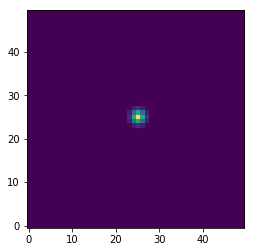

In [10]:
test_params = [25,25]
plt.imshow(compute_model(test_params,50),origin='lower');

# 3. Try with EnsembleSampler

In [11]:
# Set up the emcee sampler
ndim=2
nwalkers=100

# Construct the EnsembleSampler object using the posterior
sampler = emcee.EnsembleSampler(nwalkers, ndim, get_ln_post, args=[image])

Let's use an initial guess near the bottom left point source

In [12]:
p0_bl = emcee.utils.sample_ball((15,15),(5,5),nwalkers)

Now run the EnsembleSampler near this source

In [13]:
%%time
pos, _ , _ = sampler.run_mcmc(p0_bl,1000);

CPU times: user 15.6 s, sys: 134 ms, total: 15.8 s
Wall time: 16.1 s


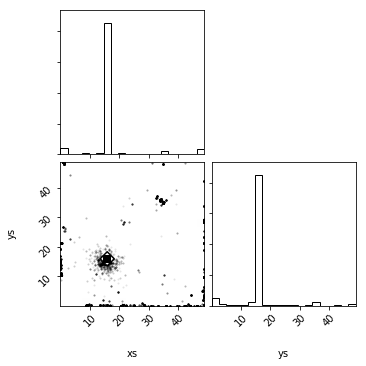

In [14]:
corner.corner(sampler.flatchain, labels=['xs', 'ys']);

After 100 walkers going for 1000 steps, it seems like we only find the closest peak (stuck in local maxima). There is a hint of another peak though.

What happens if we try this near the top right source?

In [15]:
# Construct a new EnsembleSampler object
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, get_ln_post, args=[image])
# Start initial guess near top right source
p0_tr = emcee.utils.sample_ball((35,35),(5,5),nwalkers)

In [16]:
%%time
pos, _ , _ = sampler2.run_mcmc(p0_tr,1000);

CPU times: user 16.5 s, sys: 187 ms, total: 16.7 s
Wall time: 18 s


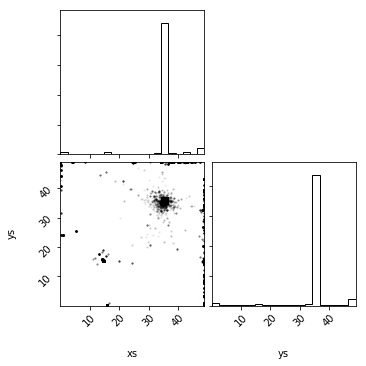

In [17]:
corner.corner(sampler2.flatchain, labels=['xs', 'ys']);

Okay, so we now mostly get the other closest source. What if we tried to spread the walkers across the whole image?

In [18]:
# Construct a new EnsembleSampler object
sampler3 = emcee.EnsembleSampler(nwalkers, ndim, get_ln_post, args=[image])
# Start initial guess near top right source
p0_all = emcee.utils.sample_ball((25,25),(15,15),nwalkers)

In [19]:
%%time
pos, _ , _ = sampler3.run_mcmc(p0_all,1000);

//anaconda/envs/emcee_workshop/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
//anaconda/envs/emcee_workshop/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


CPU times: user 16.1 s, sys: 184 ms, total: 16.3 s
Wall time: 17.4 s


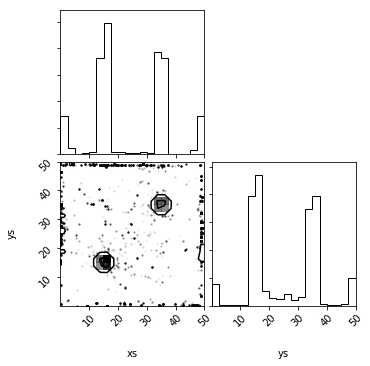

In [20]:
corner.corner(sampler3.flatchain, labels=['xs', 'ys'], range=((0,50),(0,50)));

# 4. Can Parallel Tempering help?

Let's try this again with parallel tempering!

In [21]:
ntemps=20
ndim=2
nwalkers=100

In [22]:
p0_PT = np.random.uniform(low=0, high=49, size=(ntemps, nwalkers, ndim))

In [23]:
sampler_PT = ptemcee.Sampler(nwalkers,ndim,get_ln_like,get_ln_prior,loglargs=[image],logpargs=[image],ntemps=ntemps)

In [24]:
sampler_PT.reset()

In [25]:
%%time
pos, _ , _ = sampler_PT.run_mcmc(p0_PT,1000);

CPU times: user 4min 20s, sys: 766 ms, total: 4min 21s
Wall time: 4min 23s


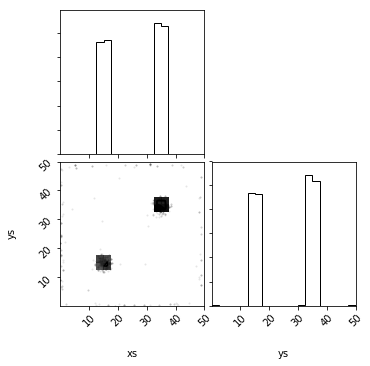

In [26]:
corner.corner(sampler_PT.flatchain[0,:,:], labels=['xs', 'ys'], range=((0,50),(0,50)));